# Import Library

In [1]:
import math
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Average, Dropout, Dense, Concatenate, LSTM, Conv1D, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import Adam, RMSprop  
start_date='2010-01-01'
end_date='2020-12-31'

In [33]:
pd.options.mode.chained_assignment = None  # ปิดคำเตือน SettingWithCopyWarning

# Paremeter model setting

In [2]:
early_stopping_patience = 10
model_checkpoint_file_lstm = 'LSTM_Model.h5'
model_checkpoint_file_ensemble = 'Ensemble_Model.h5'
early_stopping = EarlyStopping(monitor='loss', patience=early_stopping_patience, verbose=1, restore_best_weights=True)
model_checkpoint_lstm = ModelCheckpoint(model_checkpoint_file_lstm, monitor='loss', save_best_only=True, verbose=1)
model_checkpoint_ensemble = ModelCheckpoint(model_checkpoint_file_ensemble, monitor='loss', save_best_only=True, verbose=1)

# Read Data

In [3]:
df = fdr.DataReader('AMZN', start=start_date, end=end_date)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,6.812500,6.830500,6.657000,6.695000,6.695000,151998000
2010-01-05,6.671500,6.774000,6.590500,6.734500,6.734500,177038000
2010-01-06,6.730000,6.736500,6.582500,6.612500,6.612500,143576000
2010-01-07,6.600500,6.616000,6.440000,6.500000,6.500000,220604000
2010-01-08,6.528000,6.684000,6.451500,6.676000,6.676000,196610000
...,...,...,...,...,...,...
2020-12-23,160.250000,160.506500,159.208496,159.263504,159.263504,41876000
2020-12-24,159.695007,160.100006,158.449997,158.634506,158.634506,29038000
2020-12-28,159.699997,165.199997,158.634506,164.197998,164.197998,113736000


## EDA (Exploratory Data Analysis)

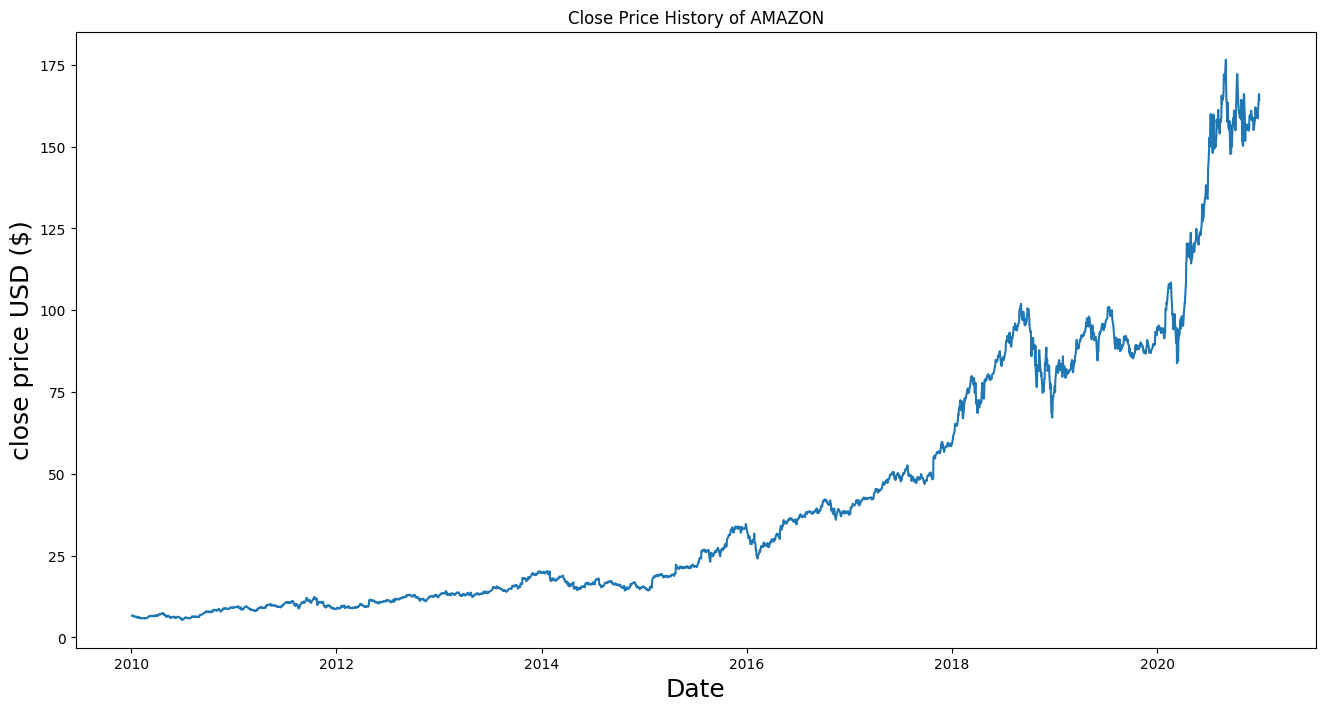

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close Price History of AMAZON')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('close price USD ($)',fontsize=18)
plt.show()

# Preprocessing Data

In [5]:
data = df.filter(['Close'])

dataset = data.values

training_data_len = math.ceil(len(dataset) * .8 )

training_data_len

2215

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.0073886 ],
       [0.0076194 ],
       [0.00690655],
       ...,
       [0.92769456],
       [0.93880819],
       [0.92824672]])

In [7]:
train_data = scaled_data[0:training_data_len , :]

In [8]:
x_train = []
y_train = []
for i in range(120, len(train_data)):
    x_train.append(train_data[i-120:i, 0])
    y_train.append(train_data[i,0])

In [9]:
x_train = np.array(x_train)
y_train = np.array(y_train)

# Create model

1. **LSTM Model**

In [10]:
input_layer = Input(shape=(x_train.shape[1], 1)) 

conv1d_layer = Conv1D(32, kernel_size=3, strides=1, activation='relu')(input_layer)

lstm_layer = LSTM(128, activation='tanh')(conv1d_layer)

batch_norm_layer = BatchNormalization()(lstm_layer)

dropout_layer = Dropout(0.2)(batch_norm_layer)

dense_layer = Dense(1)(dropout_layer)

lstm_model = Model(inputs=input_layer, outputs=dense_layer)

optimizer = Adam(learning_rate=0.0005)  
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 118, 32)           128       
                                                                 
 lstm (LSTM)                 (None, 128)               82432     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                             

In [11]:
lstm_model.fit(x_train, y_train, batch_size=32, epochs=100,callbacks=[early_stopping, model_checkpoint_lstm])

Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 0.0149 - mae: 0.0769
Epoch 1: loss improved from inf to 0.01493, saving model to LSTM_Model.h5
66/66 [==============================] - 12s 113ms/step - loss: 0.0149 - mae: 0.0769
Epoch 2/100
 1/66 [..............................] - ETA: 6s - loss: 0.0079 - mae: 0.0749

C:\Users\tam05\anaconda3\envs\pytorch\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - ETA: 0s - loss: 0.0050 - mae: 0.0477
Epoch 2: loss improved from 0.01493 to 0.00504, saving model to LSTM_Model.h5
66/66 [==============================] - 8s 116ms/step - loss: 0.0050 - mae: 0.0477
Epoch 3/100
66/66 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0378
Epoch 3: loss improved from 0.00504 to 0.00305, saving model to LSTM_Model.h5
66/66 [==============================] - 7s 111ms/step - loss: 0.0030 - mae: 0.0378
Epoch 4/100
66/66 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0343
Epoch 4: loss improved from 0.00305 to 0.00219, saving model to LSTM_Model.h5
66/66 [==============================] - 7s 105ms/step - loss: 0.0022 - mae: 0.0343
Epoch 5/100
66/66 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0280
Epoch 5: loss improved from 0.00219 to 0.00148, saving model to LSTM_Model.h5
66/66 [==============================] - 7s 104ms/step - loss: 0.0015 - mae: 0.0280
Epoc

In [12]:
test_data = scaled_data[training_data_len - 120: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(120, len(test_data)):
    x_test.append(test_data[i-120:i, 0])

In [13]:
x_test = np.array(x_test)

In [14]:
predictions = lstm_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

18/18 [==============================] - 1s 40ms/step


2. **Ensemble model AVG(LSTM+GRU+RNN)**

In [17]:
input_layer = Input(shape=((x_train.shape[1], 1)))  

rnn_layer = SimpleRNN(128, activation='tanh')(input_layer)

lstm_layer = LSTM(128, activation='tanh')(input_layer)

gru_layer = GRU(128, activation='tanh')(input_layer)

average_layer = Average()([rnn_layer, lstm_layer, gru_layer])

dropout_layer = Dropout(0.2)(average_layer)

dense_layer1 = Dense(32, activation='relu')(dropout_layer)

dense_layer2 = Dense(1)(dense_layer1)

Ensemble_Model = Model(inputs=input_layer, outputs=dense_layer2)

from keras.optimizers import Adam
optimizer = RMSprop(learning_rate=0.0005)
Ensemble_Model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

Ensemble_Model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 1)]             0         []                            
                                                                                                  
 simple_rnn (SimpleRNN)      (None, 128)                  16640     ['input_2[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, 128)                  66560     ['input_2[0][0]']             
                                                                                                  
 gru (GRU)                   (None, 128)                  50304     ['input_2[0][0]']             
                                                                                            

In [18]:
Ensemble_Model.fit(x_train, y_train, batch_size=32, epochs=100,callbacks=[early_stopping, model_checkpoint_ensemble])

Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 0.0052 - mae: 0.0368
Epoch 1: loss improved from inf to 0.00521, saving model to Ensemble_Model.h5
66/66 [==============================] - 17s 161ms/step - loss: 0.0052 - mae: 0.0368
Epoch 2/100


C:\Users\tam05\anaconda3\envs\pytorch\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - ETA: 0s - loss: 4.6514e-04 - mae: 0.0132
Epoch 2: loss improved from 0.00521 to 0.00047, saving model to Ensemble_Model.h5
66/66 [==============================] - 11s 160ms/step - loss: 4.6514e-04 - mae: 0.0132
Epoch 3/100
66/66 [==============================] - ETA: 0s - loss: 2.9117e-04 - mae: 0.0111
Epoch 3: loss improved from 0.00047 to 0.00029, saving model to Ensemble_Model.h5
66/66 [==============================] - 11s 166ms/step - loss: 2.9117e-04 - mae: 0.0111
Epoch 4/100
66/66 [==============================] - ETA: 0s - loss: 2.4242e-04 - mae: 0.0104
Epoch 4: loss improved from 0.00029 to 0.00024, saving model to Ensemble_Model.h5
66/66 [==============================] - 11s 163ms/step - loss: 2.4242e-04 - mae: 0.0104
Epoch 5/100
66/66 [==============================] - ETA: 0s - loss: 2.3924e-04 - mae: 0.0099
Epoch 5: loss improved from 0.00024 to 0.00024, saving model to Ensemble_Model.h5
66/66 [==============================] - 

Epoch 35/100
66/66 [==============================] - ETA: 0s - loss: 9.6499e-05 - mae: 0.0067
Epoch 35: loss did not improve from 0.00009
66/66 [==============================] - 11s 164ms/step - loss: 9.6499e-05 - mae: 0.0067
Epoch 36/100
66/66 [==============================] - ETA: 0s - loss: 9.9363e-05 - mae: 0.0069
Epoch 36: loss did not improve from 0.00009
66/66 [==============================] - 11s 166ms/step - loss: 9.9363e-05 - mae: 0.0069
Epoch 37/100
66/66 [==============================] - ETA: 0s - loss: 9.3168e-05 - mae: 0.0069
Epoch 37: loss improved from 0.00009 to 0.00009, saving model to Ensemble_Model.h5
66/66 [==============================] - 11s 170ms/step - loss: 9.3168e-05 - mae: 0.0069
Epoch 38/100
66/66 [==============================] - ETA: 0s - loss: 9.9216e-05 - mae: 0.0069
Epoch 38: loss did not improve from 0.00009
66/66 [==============================] - 11s 163ms/step - loss: 9.9216e-05 - mae: 0.0069
Epoch 39/100
66/66 [=============================

66/66 [==============================] - 11s 172ms/step - loss: 7.4147e-05 - mae: 0.0061
Epoch 70/100
66/66 [==============================] - ETA: 0s - loss: 7.5856e-05 - mae: 0.0062
Epoch 70: loss did not improve from 0.00007
66/66 [==============================] - 11s 159ms/step - loss: 7.5856e-05 - mae: 0.0062
Epoch 71/100
66/66 [==============================] - ETA: 0s - loss: 7.7807e-05 - mae: 0.0062
Epoch 71: loss did not improve from 0.00007
66/66 [==============================] - 11s 161ms/step - loss: 7.7807e-05 - mae: 0.0062
Epoch 72/100
66/66 [==============================] - ETA: 0s - loss: 7.4038e-05 - mae: 0.0060
Epoch 72: loss did not improve from 0.00007
66/66 [==============================] - 10s 159ms/step - loss: 7.4038e-05 - mae: 0.0060
Epoch 73/100
66/66 [==============================] - ETA: 0s - loss: 8.6730e-05 - mae: 0.0064
Epoch 73: loss did not improve from 0.00007
66/66 [==============================] - 11s 162ms/step - loss: 8.6730e-05 - mae: 0.0064

In [19]:
predictions_en = Ensemble_Model.predict(x_test)
predictions_en = scaler.inverse_transform(predictions_en)

18/18 [==============================] - 2s 44ms/step


# Evaluate Model

In [27]:
rsme = np.sqrt( np.mean( predictions - y_test )**2 )
print(f'RMSE of LSTM Model: {rsme}')

RMSE of LSTM Model: 6.817685952138724


In [28]:
rsme_en = np.sqrt( np.mean( predictions_en - y_test )**2 )
print(f'RMSE of Ensemble Model: {rsme_en}')

RMSE of Ensemble Model: 3.4495568496491082


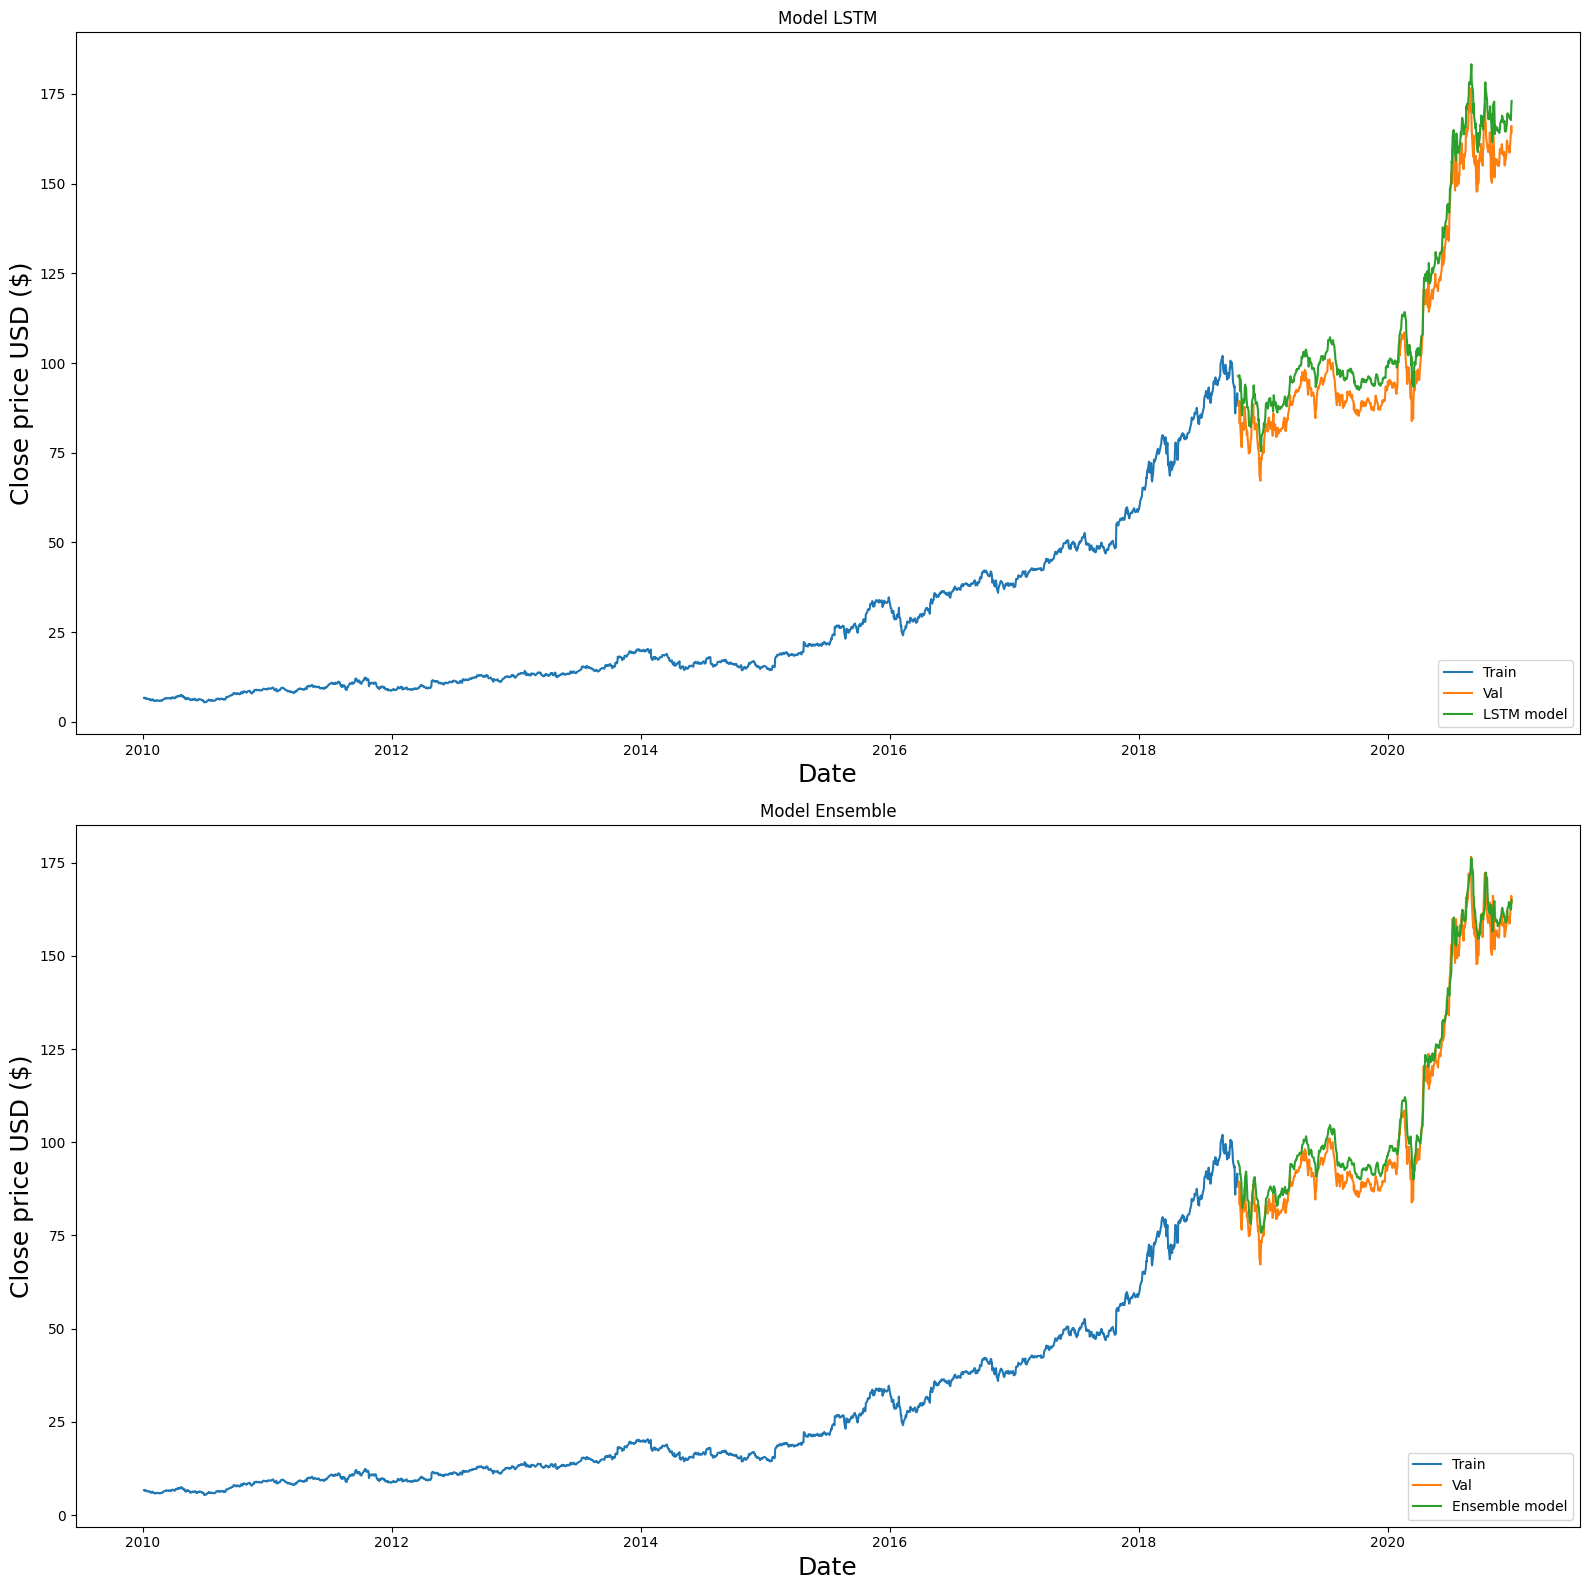

In [35]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid_en = data[training_data_len:]
valid.loc[:, 'Predictions'] = predictions
valid_en.loc[:, 'Predictions'] = predictions_en

fig, axes = plt.subplots(2, 1, figsize=(16, 16))

# Plot for LSTM Model
axes[0].set_title('Model LSTM')
axes[0].set_xlabel('Date', fontsize=18)
axes[0].set_ylabel('Close price USD ($)', fontsize=18)
axes[0].plot(train['Close'])
axes[0].plot(valid[['Close', 'Predictions']])
axes[0].legend(['Train', 'Val', 'LSTM model'], loc='lower right')

# Plot for Ensemble Model
axes[1].set_title('Model Ensemble')
axes[1].set_xlabel('Date', fontsize=18)
axes[1].set_ylabel('Close price USD ($)', fontsize=18)
axes[1].plot(train['Close'])
axes[1].plot(valid_en[['Close', 'Predictions']])
axes[1].legend(['Train', 'Val', 'Ensemble model'], loc='lower right')

plt.tight_layout()
plt.show()